#Data

In [1]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip tiny-imagenet-200.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating

In [2]:
import os, io
from pathlib import Path
from typing import Tuple
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

# ====== Rutas y constantes ======
DATA_ROOT = Path("/content/tiny-imagenet-200")  # ajusta si lo descomprimiste en otro sitio
TRAIN_DIR = DATA_ROOT / "train"
VAL_DIR   = DATA_ROOT / "val"
NUM_CLASSES = 200

# ====== Dataset de validación para Tiny-ImageNet ======
class TinyImageNetVal(Dataset):
    """
    Lee val/images y val_annotations.txt (formato: filename \t wnid \t x1 y1 x2 y2)
    y usa el mapping de clases de train (class_to_idx) para obtener los índices.
    """
    def __init__(self, val_dir: Path, class_to_idx: dict, transform=None):
        self.val_dir = Path(val_dir)
        self.images_dir = self.val_dir / "images"
        self.ann_path = self.val_dir / "val_annotations.txt"
        self.class_to_idx = class_to_idx
        self.transform = transform

        # parse annotations
        mapping = {}  # filename -> wnid
        with open(self.ann_path, "r") as f:
            for line in f:
                # filename, wnid, x1, y1, x2, y2 (separados por \t o espacio)
                parts = line.strip().split()
                if len(parts) >= 2:
                    mapping[parts[0]] = parts[1]

        # construir lista de (path, target)
        self.samples = []
        for fname, wnid in mapping.items():
            p = self.images_dir / fname
            if p.exists() and wnid in self.class_to_idx:
                self.samples.append((str(p), self.class_to_idx[wnid]))

        if len(self.samples) == 0:
            raise RuntimeError("No se construyeron muestras para validación. Revisa rutas y val_annotations.txt")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        path, target = self.samples[idx]
        with Image.open(path) as im:
            im = im.convert("RGB")
        if self.transform is not None:
            im = self.transform(im)
        return im, target

# ====== Transforms (puedes reusar los del pipeline) ======
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

# ====== Datasets base ======
train_base = datasets.ImageFolder(str(TRAIN_DIR))  # sin transform aquí (lo pones en los loaders)
# class_to_idx viene de train (200 clases)
class_to_idx = train_base.class_to_idx
val_base   = TinyImageNetVal(VAL_DIR, class_to_idx=class_to_idx, transform=None)  # sin transform aquí

print("Clases (ejemplo):", list(class_to_idx)[:5])
print("Train imgs:", len(train_base.samples))
print("Val imgs  :", len(val_base))

# ====== Loaders para la fase supervisada (enchufables al pipeline) ======
BATCH = 128
train_sup_loader = DataLoader(
    datasets.ImageFolder(str(TRAIN_DIR), transform=train_tf),
    batch_size=BATCH, shuffle=True, num_workers=4, pin_memory=True
)
val_sup_loader = DataLoader(
    TinyImageNetVal(VAL_DIR, class_to_idx=class_to_idx, transform=val_tf),
    batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True
)





Clases (ejemplo): ['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640']
Train imgs: 100000
Val imgs  : 10000


In [5]:
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image

# ---- Si aún no tienes train_base (Tiny-ImageNet) descomenta y ajusta ruta ----
# from pathlib import Path
# TRAIN_DIR = Path("/content/tiny-imagenet-200/train")
# train_base = datasets.ImageFolder(str(TRAIN_DIR))   # <-- SIN transform aquí

class RotNetWrapper(Dataset):
    """Envuelve un dataset de imágenes para pretexto RotNet (0,90,180,270 grados)."""
    rots = (0, 90, 180, 270)

    def __init__(self, base_ds, img_size=224):
        self.base = base_ds
        self.to_tensor = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),      # sin normalizar en pretexto
        ])

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        x, _ = self.base[idx]          # ignoramos la etiqueta real
        # Asegurar que sea PIL para rotar limpio
        if isinstance(x, torch.Tensor):
            x = transforms.ToPILImage()(x)
        k = random.randint(0, 3)       # clase de rotación
        x = transforms.functional.rotate(x, self.rots[k])
        x = self.to_tensor(x)
        return x, k


In [6]:
#====== Loader para la fase de pretexto (RotNet) ======
train_pretext = RotNetWrapper(train_base, img_size=224)
train_pre_loader = DataLoader(train_pretext, batch_size=BATCH, shuffle=True, num_workers=4, pin_memory=True)

In [7]:
import copy, torch, torch.nn as nn, torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import random
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Wrapper RotNet (si ya lo tienes, omite esto) ---
class RotNetWrapper(Dataset):
    rots = [0, 90, 180, 270]
    def __init__(self, base_ds, img_size=224):
        self.base = base_ds
        self.to_tensor = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),  # sin normalizar
        ])
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        x, _ = self.base[idx]
        if isinstance(x, torch.Tensor): x = transforms.ToPILImage()(x)
        k = random.randint(0,3)
        x = transforms.functional.rotate(x, self.rots[k])
        x = self.to_tensor(x)
        return x, k

# --- DataLoader de pretexto (usa el train_base que ya construiste) ---
BATCH = 128
train_pre_loader = DataLoader(
    RotNetWrapper(train_base, img_size=224),
    batch_size=BATCH, shuffle=True, num_workers=4, pin_memory=True
)

# --- Modelo: ResNet18 con cabeza de 4 clases (rotaciones) ---
rot_model = models.resnet18(weights=None)
rot_model.fc = nn.Linear(rot_model.fc.in_features, 4)
rot_model = rot_model.to(device)

# --- Entrenamiento rápido con AMP ---
crit = nn.CrossEntropyLoss()
opt  = optim.AdamW(rot_model.parameters(), lr=1e-3, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

def train_rotnet_epoch(model, loader):
    model.train()
    tot=0; ok=0; loss_sum=0.0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(x)
            loss = crit(logits, y)
        scaler.scale(loss).backward()
        scaler.step(opt); scaler.update()
        loss_sum += loss.item()*x.size(0)
        ok += (logits.argmax(1)==y).sum().item()
        tot += x.size(0)
    return loss_sum/tot, ok/tot

EPOCHS_PRETEXT = 10
for e in range(1, EPOCHS_PRETEXT+1):
    L, acc = train_rotnet_epoch(rot_model, train_pre_loader)
    print(f"[Pretext] {e:02d}/{EPOCHS_PRETEXT}  loss={L:.4f}  acc={acc:.3f}")

# --- Guardar backbone (sin la capa fc) ---
backbone = copy.deepcopy(rot_model)
backbone.fc = nn.Identity()
torch.save(backbone.state_dict(), "/content/backbone_rotnet_resnet18.pth")
print("Backbone guardado.")


/tmp/ipython-input-2561513119.py:42: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
/tmp/ipython-input-2561513119.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[Pretext] 01/10  loss=1.2625  acc=0.415
[Pretext] 02/10  loss=1.1707  acc=0.477
[Pretext] 03/10  loss=1.0863  acc=0.534
[Pretext] 04/10  loss=1.0113  acc=0.577
[Pretext] 05/10  loss=0.9529  acc=0.608
[Pretext] 06/10  loss=0.9046  acc=0.632
[Pretext] 07/10  loss=0.8620  acc=0.652
[Pretext] 08/10  loss=0.8263  acc=0.668
[Pretext] 09/10  loss=0.7931  acc=0.683
[Pretext] 10/10  loss=0.7614  acc=0.697
Backbone guardado.


In [8]:
from torchvision import models
import torch.nn.functional as F

NUM_CLASSES = 200

# --- Modelo supervisado ---
sup_model = models.resnet18(weights=None)
sup_model.fc = nn.Linear(sup_model.fc.in_features, NUM_CLASSES)
sup_model = sup_model.to(device)

# --- Cargar backbone entrenado (ignorando la fc) ---
state = torch.load("/content/backbone_rotnet_resnet18.pth", map_location='cpu')
missing, unexpected = sup_model.load_state_dict(state, strict=False)
print("Missing keys:", missing)        # debería listar fc.*
print("Unexpected keys:", unexpected)

# --- Optimizador: LR menor al backbone, mayor a la cabeza ---
head_params = list(sup_model.fc.parameters())
back_params = [p for n,p in sup_model.named_parameters() if not n.startswith("fc.")]
opt = optim.AdamW([
    {"params": back_params, "lr": 2e-4},
    {"params": head_params, "lr": 1e-3},
], weight_decay=1e-4)

crit = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

def topk_acc(logits, y, k=5):
    with torch.no_grad():
        _, pred = logits.topk(k, dim=1)
        return (pred.eq(y.view(-1,1)).any(dim=1).float().mean().item())

def train_epoch(model, loader):
    model.train()
    tot=0; ok1=0; loss_sum=0.0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(x)
            loss = crit(logits, y)
        scaler.scale(loss).backward()
        scaler.step(opt); scaler.update()
        loss_sum += loss.item()*x.size(0)
        ok1 += (logits.argmax(1)==y).sum().item()
        tot += x.size(0)
    return loss_sum/tot, ok1/tot

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    tot=0; ok1=0; ok5=0; loss_sum=0.0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(x)
            loss = crit(logits, y)
        loss_sum += loss.item()*x.size(0)
        ok1 += (logits.argmax(1)==y).sum().item()
        ok5 += (torch.topk(logits, 5, dim=1).indices.eq(y.view(-1,1)).any(dim=1)).sum().item()
        tot += x.size(0)
    return loss_sum/tot, ok1/tot, ok5/tot

EPOCHS_SUP = 15
best = 0.0; best_w = None
for e in range(1, EPOCHS_SUP+1):
    trL, trA = train_epoch(sup_model, train_sup_loader)
    vaL, vaA1, vaA5 = evaluate(sup_model, val_sup_loader)
    if vaA1 > best:
        best = vaA1; best_w = copy.deepcopy(sup_model.state_dict())
    print(f"[Sup] {e:02d}/{EPOCHS_SUP}  train_acc={trA:.3f}  val_acc@1={vaA1:.3f}  val_acc@5={vaA5:.3f}")

if best_w:
    sup_model.load_state_dict(best_w)
    torch.save(sup_model.state_dict(), "/content/resnet18_tinyimagenet_finetuned.pth")
    print(f"Mejor val@1={best:.3f} guardado.")


Missing keys: ['fc.weight', 'fc.bias']
Unexpected keys: []


/tmp/ipython-input-1007881705.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
/tmp/ipython-input-1007881705.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1007881705.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[Sup] 01/15  train_acc=0.111  val_acc@1=0.193  val_acc@5=0.455
[Sup] 02/15  train_acc=0.217  val_acc@1=0.251  val_acc@5=0.530
[Sup] 03/15  train_acc=0.270  val_acc@1=0.298  val_acc@5=0.579
[Sup] 04/15  train_acc=0.308  val_acc@1=0.326  val_acc@5=0.611
[Sup] 05/15  train_acc=0.341  val_acc@1=0.350  val_acc@5=0.630
[Sup] 06/15  train_acc=0.368  val_acc@1=0.373  val_acc@5=0.656
[Sup] 07/15  train_acc=0.388  val_acc@1=0.388  val_acc@5=0.666
[Sup] 08/15  train_acc=0.411  val_acc@1=0.391  val_acc@5=0.674
[Sup] 09/15  train_acc=0.428  val_acc@1=0.415  val_acc@5=0.693
[Sup] 10/15  train_acc=0.444  val_acc@1=0.427  val_acc@5=0.707
[Sup] 11/15  train_acc=0.461  val_acc@1=0.433  val_acc@5=0.713
[Sup] 12/15  train_acc=0.476  val_acc@1=0.450  val_acc@5=0.722
[Sup] 13/15  train_acc=0.487  val_acc@1=0.446  val_acc@5=0.721
[Sup] 14/15  train_acc=0.503  val_acc@1=0.460  val_acc@5=0.733
[Sup] 15/15  train_acc=0.514  val_acc@1=0.472  val_acc@5=0.743
Mejor val@1=0.472 guardado.


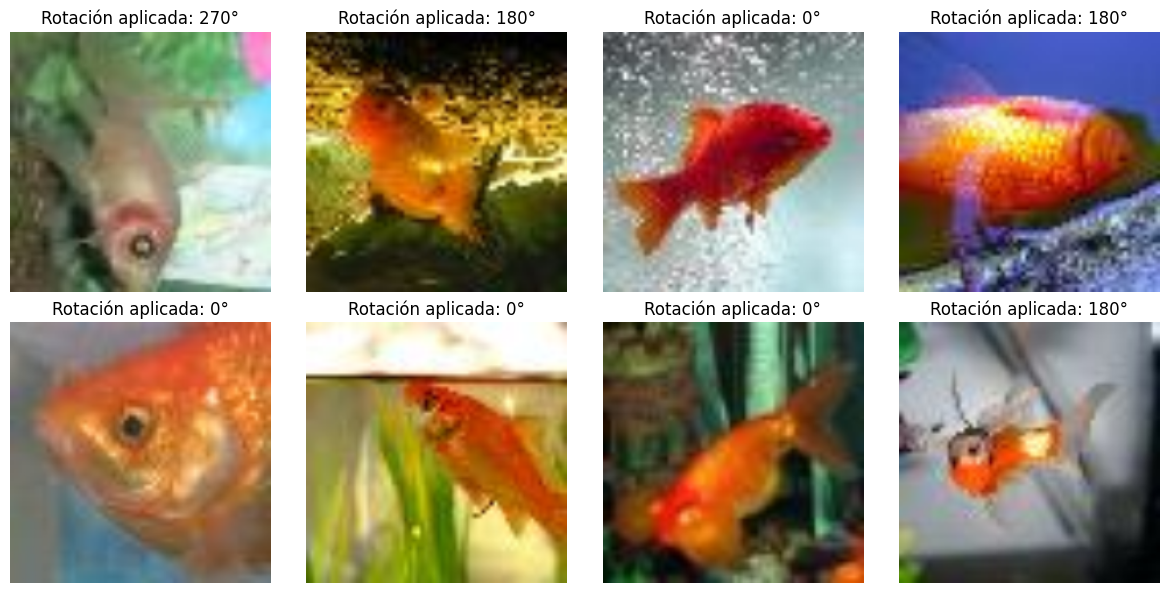

In [9]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# --- Diccionario de rotaciones ---
rot_labels = {0: "0°", 1: "90°", 2: "180°", 3: "270°"}

def visualize_rotnet_samples(dataset, n=8):
    """
    Muestra ejemplos de cómo RotNet transforma las imágenes.
    dataset = RotNetWrapper(...)
    """
    plt.figure(figsize=(12, 6))
    for i in range(n):
        img, rot_class = dataset[i]

        # Convertir a imagen para mostrar
        npimg = img.permute(1,2,0).numpy()

        plt.subplot(2, n//2, i+1)
        plt.imshow(npimg)
        plt.title(f"Rotación aplicada: {rot_labels[rot_class]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# --- Ejecutar visualización ---
visualize_rotnet_samples(train_pretext, n=8)
